In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import xarray as xr
from scipy.spatial import cKDTree
import glob
import argparse
from mpl_toolkits.basemap import Basemap
import scipy.stats as stats
import netCDF4 as nc
import wavespectra
import cmocean
from datetime import datetime, timedelta
import scipy.io


In [ ]:
# base_path = '/home/dvdhoorn/hurrywave_runs'
base_path = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/04_modelruns/YearSims'

year_start = 2009
year_end = 2015
# model_name = '2013'
model_names = [str(year) for year in range(year_start, year_end + 1)]
model_paths = [os.path.join(base_path, model_name) for model_name in model_names]

# nc_file = os.path.join(model_path,'hurrywave_sp2.nc')
# inp_file = os.path.join(model_path,'hurrywave.inp')

# if os.path.exists(os.path.join(model_path, 'hurrywave.log')):
#     log_file = os.path.join(model_path, 'hurrywave.log')
# else:
#     log_file = None
#     print('WARNING: Log file not found at:', log_file)

postprocess_path = os.path.join(base_path, '2009to2015')
filepath_data = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/spectral_buoy_data'
timestep = 500
lat_A12 = 55.399167
lon_A12 = 3.810278


In [3]:
def get_dt(inp_file, log_file):
    dt = None
    if log_file and os.path.exists(log_file):
        with open(log_file, 'r') as f:
            for line in f:
                if 'Warning! Reducing dt from' in line:
                    parts = line.strip().split('to')
                    if len(parts) == 2:
                        try:
                            dt = float(parts[1].split()[0])
                            print('taking dt from log file')
                            print(f'dt found in log file: {dt} s')
                            return dt
                        except Exception:
                            pass
    # If not found in log file, read from input file
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('dt'):
                parts = line.split('=')
                if len(parts) == 2:
                    try:
                        dt = float(parts[1].split(',')[0].strip())
                        print('taking dt from input file')
                        print(f'dt found in input file: {dt} s')
                        return dt
                    except Exception:
                        pass
    raise ValueError("dt could not be found in log or input file")

def get_spectra_output_dt(inp_file):
    dtsp2out = None
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('dtsp2out'):
                parts = line.split('=')
                if len(parts) == 2:
                    try:
                        dtsp2out = float(parts[1].split(',')[0].strip())
                        print(f'spectra output dt found in input file: {dtsp2out} s')
                        return dtsp2out
                    except Exception:
                        pass
    print("WARNING: dtsp2out not found in input file")
    return None

def get_timesteps(inp_file, log_file):
    # Read tstart and tend from inp_file
    tstart = None
    tend = None
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tstart'):
                tstart_str = line.split('=')[1].strip().split(',')[0]
                tstart = datetime.strptime(tstart_str, "%Y%m%d %H%M%S")
            if line.strip().startswith('tstop'):
                tstop_str = line.split('=')[1].strip().split(',')[0]
                tstop = datetime.strptime(tstop_str, "%Y%m%d %H%M%S")
    if tstart is None or tstop is None:
        raise ValueError("tstart or tend not found in inp file")

    dt = get_spectra_output_dt(inp_file)
    nsteps = int((tstop - tstart).total_seconds() // dt) + 1

    # Remove the spinup times
    t_spinup = None
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tspinup'):
                t_spinup_str = line.split('=')[1].strip().split(',')[0]
                t_spinup = float(t_spinup_str)
                break
    if t_spinup is None:
        raise ValueError("tspinup not found in input file")
    

    time_steps = np.array([tstart + timedelta(seconds=i*dt) for i in range(nsteps)])

    # Remove the spinup times
    # Remove all time steps before tstart + tspinup seconds
    spinup_end_time = tstart + timedelta(seconds=t_spinup)
    time_steps = time_steps[time_steps >= spinup_end_time]

    return time_steps

for model_name in model_names:
    model_path = os.path.join(base_path, model_name)
    inp_file = os.path.join(model_path, 'hurrywave.inp')
    log_file = os.path.join(model_path, 'hurrywave.log') if os.path.exists(os.path.join(model_path, 'hurrywave.log')) else None

    this_model_timesteps = get_timesteps(inp_file, log_file)
    model_timesteps = np.concatenate((model_timesteps, this_model_timesteps)) if 'model_timesteps' in locals() else this_model_timesteps # concatenate all timesteps

    print("First timestep:", model_timesteps[0])
    print("Last timestep:", model_timesteps[-1])


spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2009-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2010-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2011-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2012-12-31 23:00:00
spectra output dt found in input file: 3600.0 s
First timestep: 2009-01-01 00:00:00
Last timestep: 2013-12-31 23:00:00


In [4]:
def ds_remove_spinup(year, model_base_path, ds):
    # Find the start and stop times from the input file
    inp_file = os.path.join(model_base_path, str(year), 'hurrywave.inp')
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tspinup'):
                tspinup = line.split('=')[1].strip()

    tspinup_sec = int(tspinup)
    ds_time_vals = ds["time"].values
    spinup_end_time = ds_time_vals[0] + np.timedelta64(tspinup_sec, 's')
    ds_spinup_mask = ds_time_vals >= spinup_end_time
    ds = ds.sel(time=ds_spinup_mask)
    return ds

In [5]:
ds = xr.open_dataset('/home/dvdhoorn/hurrywave_runs/2013/hurrywave_sp2.nc')



In [6]:
print(ds['time'].values)

['2012-12-01T00:00:00.000000000' '2012-12-01T00:10:00.000000000'
 '2012-12-01T00:20:00.000000000' ... '2013-12-31T23:40:00.000000000'
 '2013-12-31T23:50:00.000000000' '2014-01-01T00:00:00.000000000']


In [7]:
def process_station_data(model_base_path, outdir, y0, y1, save=True):
    print('Starting Hurrywave station extraction...')

    years = np.arange(y0, y1 + 1)
    data_per_station = {}
    sigma = None
    theta = None

    for y in years:
        print(f'Processing year: {y}')
        fname = os.path.join(model_base_path, str(y), 'hurrywave_sp2.nc')
        ds = xr.open_dataset(fname)
        ds = ds_remove_spinup(y, model_base_path, ds)


        nstations = ds.dims['stations']
        station_names = ds['station_name'].astype(str).values
        if sigma is None:
            sigma = ds['sigma'].values
        if theta is None:
            theta = ds['theta'].values
            theta = (270 - theta) % 360 # Convert to meteorological convention

        time = ds['time'].values
        data_vars = ['point_spectrum2d']

        for i in range(nstations):
            station = station_names[i].strip()
            print(f'  - Extracting {station}')

            if station not in data_per_station:
                data_per_station[station] = {var: [] for var in data_vars}
                data_per_station[station]['time'] = []

            for var in data_vars:
                data_per_station[station][var].append(ds[var].isel(stations=i).values)
            data_per_station[station]['time'].append(time)

        ds.close()

    for station in data_per_station:
        for key in data_per_station[station]:
            data_per_station[station][key] = np.concatenate(data_per_station[station][key])

    if save:
        print('All years loaded. Starting export...')
        os.makedirs(outdir, exist_ok=True)

        for station, data in data_per_station.items():
            outpath = os.path.join(outdir, f'{station}.npz')
            np.savez(os.path.join(outdir, 'global_coords.npz'), sigma=sigma, theta=theta)
            np.savez(outpath, **data)
            print(f'  ✓ Saved {station}.npz with {len(data["time"])} timesteps.')

        print(f'Extraction finished. Data saved to: {outdir}')
    else:
        print(f'Extraction complete. Data not saved (save=False).')

    return data_per_station, sigma, theta

In [8]:
# === Run station extraction ===
np.set_printoptions(threshold=np.inf)
ds, sigma, theta = process_station_data(
    model_base_path=base_path,
    outdir=postprocess_path,
    y0=year_start,
    y1=year_end,
    save=False
)

# === Build one big 4D array: (time, site, dir, freq) ===
site_names = list(ds.keys())
n_sites = len(site_names)
n_freq = len(sigma)
n_dir = len(theta)

# Get time length from first station
time_lens = [len(ds[site]["time"]) for site in site_names]
if not all(t == time_lens[0] for t in time_lens):
    raise ValueError("Mismatch in time lengths across stations, cannot stack directly.")

nt = time_lens[0]


Starting Hurrywave station extraction...
Processing year: 2009


/scratch-local/72649/ipykernel_2970878/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2010


/scratch-local/72649/ipykernel_2970878/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2011


/scratch-local/72649/ipykernel_2970878/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2012


/scratch-local/72649/ipykernel_2970878/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Processing year: 2013


/scratch-local/72649/ipykernel_2970878/1864478586.py:16: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Extraction complete. Data not saved (save=False).


In [9]:
# Load data
# Initialize big efth array
efth_all = np.zeros((nt, n_sites, n_dir, n_freq))
for i, site in enumerate(site_names):
    efth_all[:, i, :, :] = ds[site]["point_spectrum2d"]

# Apply scaling and remove last timestep if needed

efth_all = efth_all * 10 / (180 / np.pi)
efth_all = efth_all[:-1]
model_timesteps = ds[site_names[0]]["time"][:-1]  # use one station's time
site_coord = np.array(site_names)

# === Final DataArray ===
model_da = xr.DataArray(
    data=efth_all,
    dims=["time", "site", "dir", "freq"],
    coords=dict(
        time=model_timesteps,
        site=site_coord,
        dir=theta,
        freq=sigma,
    ),
    name="efth",
)
model_dset = model_da.to_dataset()

# def remove_spinup_from_da(model_da, inp_file):
#     t_spinup = None
#     with open(inp_file, 'r') as f:
#         for line in f:
#             if line.strip().startswith('tspinup'):
#                 t_spinup_str = line.split('=')[1].strip().split(',')[0]
#                 t_spinup = float(t_spinup_str)
#     # Remove all variables for times before t_spinup seconds after the start
#     t0 = model_da.coords['time'].values[0]
#     if isinstance(t0, np.datetime64):
#         cutoff = np.datetime64(t0) + np.timedelta64(int(t_spinup), 's')
#         model_da = model_da.sel(time=model_da.coords['time'] >= cutoff)
#     else:
#         # fallback for non-datetime time axis
#         model_da = model_da.isel(time=(model_da.coords['time'] >= t_spinup))
#     return model_da

# model_da = remove_spinup_from_da(model_da, inp_file)

In [10]:
# model_dset.spec

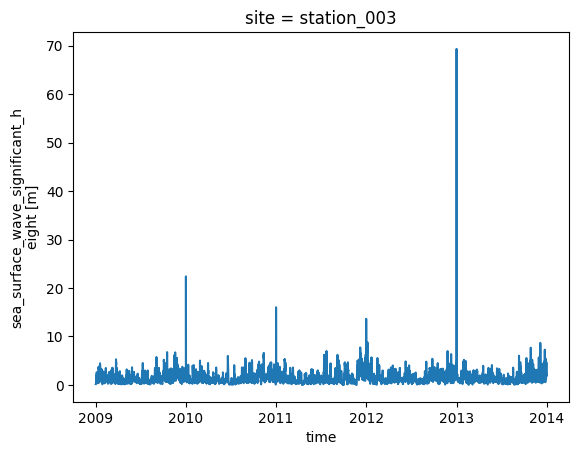

In [11]:
model_hs = model_dset.spec.hs()[:, 2]  # site index 7 corresponds to the 8th site so A12
model_hs = model_hs[:-1]
model_hs.plot.line(x="time")
plt.draw()



In [12]:
model_stats = model_dset.spec.stats(
    ["hs", "hmax", "tp", "tm01", "tm02", "dpm", "dm", "dspr", "swe"]
)

A12_model_stats = model_stats.isel(site=7)  # Select the 8th site A12
Hoorn_model_stats = model_stats.isel(site=2)  # Select the 3rd site Hoorn

# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 12))
# model_stats.hs.plot.line(ax=ax1, x="time");

# model_stats.hmax.plot.line(ax=ax2, x="time");

# model_stats.dpm.plot.line(ax=ax3, x="time");

# model_stats.dspr.plot.line(ax=ax4, x="time");

# model_stats.tp.plot.line(ax=ax5, x="time");

# model_stats.tm01.plot.line(ax=ax6, x="time");

# plt.draw()



In [13]:
def remove_hs_outliers(stats, threshold):
    """
    Remove outliers in 'hs' by setting values above the threshold to NaN.
    Returns a copy of the stats dataset with outliers removed.
    """
    stats_clean = stats.copy()
    stats_clean = stats_clean.drop_duplicates(dim='time')
    hs = stats_clean['hs']
    # Find times where hs > threshold
    outlier_times = hs['time'][hs > threshold]
    # Drop all entries at those times
    stats_clean = stats_clean.drop_sel(time=outlier_times)
    # Remove all entries at times where 'hs' is NaN
    nan_times = stats_clean['time'][np.isnan(stats_clean['hs'].values)]
    stats_clean = stats_clean.drop_sel(time=nan_times)
    return stats_clean

# Example usage:
A12_model_stats = remove_hs_outliers(A12_model_stats, threshold=50)
Hoorn_model_stats = remove_hs_outliers(Hoorn_model_stats, threshold=50)

In [14]:
def read_spectra(filepath,data_name):
    # Load .mat files
    Czz = scipy.io.loadmat(os.path.join(filepath, f'{data_name}_Czz.mat'))['Czz'].flatten()
    Th0 = scipy.io.loadmat(os.path.join(filepath, f'{data_name}_Th0.mat'))['Th0'].flatten()

    yds = datetime(2009, 2, 1, 12, 10, 0)  # A12

    vpm_Czz = 101
    vpm_Th0 = 96
    nCzz = len(Czz)
    nTh0 = len(Th0)
    nsp = nCzz // vpm_Czz

    # reconstruct time vector
    tt = np.array([yds + timedelta(minutes=10*i) for i in range(nsp)])

    # frequency and direction bins
    fw = np.concatenate(([0, 0.005], np.arange(0.015, 1.0, 0.01)))
    fd = np.concatenate(([0.03], np.arange(0.035, 0.5, 0.01)))
    nfd = len(fd)

    # time window
    ydi1, moi1, ddi1 = 2009, 2, 1
    ydi2, moi2, ddi2 = 2013, 12, 31
    ydr1 = datetime(ydi1, moi1, ddi1)
    ydr2 = datetime(ydi2, moi2, ddi2)

    ii = np.where((tt >= ydr1) & (tt <= ydr2))[0]
    ng = len(ii)
    jg = 0

    df = 0.01
    ff = np.arange(0.035, 0.485 + df, df)
    nf = len(ff)
    dtheta = 10 * np.pi / 180
    theta_r = np.arange(-np.pi, np.pi + dtheta, dtheta)
    ntheta = len(theta_r)

    Efdt = []
    Efdt_per_degree = []
    Hm0 = []
    thetap = []
    Tp = []

    for jsp in range(ii[0], ii[-1] + 1):
        jg += 1
        E = Czz[(jsp)*vpm_Czz:(jsp+1)*vpm_Czz]
        thetam = Th0[(jsp)*vpm_Th0:(jsp)*vpm_Th0+nfd]
        thetas = Th0[(jsp)*vpm_Th0+nfd:(jsp)*vpm_Th0+2*nfd]

        Ef = E[4:51]  # 5:51 in MATLAB is 4:51 in Python (0-based)
        tf = thetam[1:-1]
        sf = thetas[1:-1]

        s = np.maximum(np.round(2. / (sf * np.pi / 180) ** 2 - 1), 1)
        m = 2 * s

        Efd = np.zeros((ntheta, nf))
        for jf in range(nf):
            Dd = np.maximum(np.cos(0.5 * (theta_r - tf[jf] * np.pi / 180)) ** (m[jf]), np.finfo(float).eps)
            Ad = 1. / (np.sum(Dd) * dtheta) 
            Dd = Dd * Ad
            Efd[:, jf] = Ef[jf] * Dd

        Efd = Efd / 1e4  # to get to m2/Hz
        
        Efdt.append(Efd)
        Eff = np.sum(Efd, axis=0) * dtheta
        Ett = np.sum(Efd, axis=1) * df
        ig = np.where(ff > 0.04)[0]
        Hm0.append(4 * np.sqrt(np.sum(Eff[ig]) * df))
        it = np.argmax(Ett)
        is_ = np.argmax(Eff)
        thetap.append(theta_r[it] * 180 / np.pi)
        Tp.append(1. / ff[is_])

        # Convert to m2/degree/Hz
        dtheta_deg = dtheta * 180 / np.pi  # Convert radians to degrees (10°)
        Efd_per_degree = Efd.copy() / ( 180 / np.pi)  # Correct for external use
        Efdt_per_degree.append(Efd_per_degree)

    theta_r = theta_r * 180 / np.pi  # Convert to degrees
    theta_r = theta_r + 180 # Shift to positive degrees
    theta_r = (theta_r + 180) % 360 # Make sure the waves come from the right direction
    ttw = tt[ii]
    return {
        'ttw': ttw,
        'Hm0': np.array(Hm0),
        'thetap': np.array(thetap),
        'Tp': np.array(Tp),
        'theta_r': theta_r,
        'ff': ff,
        'Efdt': np.array(Efdt),
        'Efdt_per_degree': np.array(Efdt_per_degree)
    }
    
A12_spectra_data = read_spectra(filepath_data,'A12')
Hoorn_spectra_data = read_spectra(filepath_data,'H')

print(f"Units: data_Efdt is in m²/Hz, data_Efdt_per_degree is in m²/degree/Hz")


# # Create DataArray, with an added dimension (as in your original line)
A12_data_da = xr.DataArray(
    data=A12_spectra_data['Efdt_per_degree'],

    dims=["time","dir", "freq"],
    coords=dict(time=A12_spectra_data['ttw'],freq=A12_spectra_data['ff'], dir=A12_spectra_data['theta_r']),
    name="efth",
)

Hoorn_data_da = xr.DataArray(
    data=Hoorn_spectra_data['Efdt_per_degree'],

    dims=["time","dir", "freq"],
    coords=dict(time=Hoorn_spectra_data['ttw'],freq=Hoorn_spectra_data['ff'], dir=Hoorn_spectra_data['theta_r']),
    name="efth",
)

A12_data_dset = A12_data_da.to_dataset()
Hoorn_data_dset = Hoorn_data_da.to_dataset()



Units: data_Efdt is in m²/Hz, data_Efdt_per_degree is in m²/degree/Hz


In [15]:
import numpy as np

def read_epl_spectra(filepath, ipart=1, xaver=1, egon=0, jy=3):
    """
    Reconstruct frequency-directional spectra for Euro Platform (EPL) observations.
    
    Parameters:
        filepath: folder where .mat files are stored
        ipart: 1 for first part, 2 for second part
        xaver: 1 if only for storm XAVER
        egon: 1 if only for storm EGON
        jy: year offset for the analysis (3 for XAVER)
        
    Returns:
        Dictionary with time series, wave parameters, and spectra
    """
    # Load appropriate part
    if ipart == 1:
        Czz = scipy.io.loadmat(os.path.join(filepath, 'H_Czz_EPL3_p1.mat'))['Czz10'].flatten()
        Th0 = scipy.io.loadmat(os.path.join(filepath, 'H_Th0_EPL3_p1.mat'))['Th010'].flatten()
        Sh0 = scipy.io.loadmat(os.path.join(filepath, 'H_Sh0_EPL3_p1.mat'))['Sh010'].flatten()
        yds = datetime(2010, 1, 1, 0, 0, 0)
    else:
        Czz = scipy.io.loadmat(os.path.join(filepath, 'H_Czz_EPL3_p2.mat'))['Czz10'].flatten()
        Th0 = scipy.io.loadmat(os.path.join(filepath, 'H_Th0_EPL3_p2.mat'))['Th010'].flatten()
        Sh0 = scipy.io.loadmat(os.path.join(filepath, 'H_Sh0_EPL3_p2.mat'))['Sh010'].flatten()
        yds = datetime(2016, 8, 5, 0, 0, 0)

    # Parameters
    vpm_Czz = 51
    vpm_Th0 = 51
    vpm_Sh0 = 51
    nCzz = len(Czz)
    nTh0 = len(Th0)
    nSh0 = len(Sh0)
    nsp = nCzz // vpm_Czz

    # Time vector (10-minute intervals)
    tt = np.array([yds + timedelta(minutes=10*i) for i in range(nsp)])

    # Frequency and directional bins
    fw = np.arange(0, 0.51, 0.01)
    fd = np.arange(0, 0.51, 0.01)
    nfd = len(fd)

    # Define start and end datetime
    ydi1, moi1, ddi1 = 2010 + jy, 1, 1
    if xaver == 1:
        moi1 = 12
    if egon == 1:
        moi1, ddi1 = 1, 11
    ydr1 = datetime(ydi1, moi1, ddi1, 0, 0, 0)

    ydi2 = 2010 + jy
    if jy == 6 and ipart == 1:
        moi2, ddi2 = 8, 5
        ydr2 = datetime(ydi2, moi2, ddi2, 23, 40, 0)
    else:
        moi2, ddi2 = 12, 31
        if xaver == 1:
            ddi2 = 10
        if egon == 1:
            moi2, ddi2 = 1, 15
        ydr2 = datetime(ydi2, moi2, ddi2, 0, 0, 0) + timedelta(days=1)

    # Hourly averaging
    Dhr = 1
    nhr = Dhr * 6  # number of 10-min intervals per hour
    ii = np.where((tt > ydr1) & (tt < ydr2))[0]
    ng = round(len(ii) / nhr)

    # Preallocate arrays
    Hm0 = []
    Tp = []
    Dspr_mean = []
    theta_mean = []
    fm_01 = []
    fm_10 = []
    fm_20 = []
    tth = []
    Efdt = []
    Efdt_per_degree = []

    df = 0.01
    ff = fw[4:51]  # MATLAB 5:51 -> Python 4:51
    nf = len(ff)
    dtheta = 10 * np.pi / 180
    theta_r = np.arange(-np.pi, np.pi + dtheta, dtheta)
    ntheta = len(theta_r)

    for jg, jsp in enumerate(range(ii[0], ii[-1], nhr)):
        E = np.zeros(vpm_Czz)
        thetamx = np.zeros(nfd)
        thetamy = np.zeros(nfd)
        thetas = np.zeros(nfd)

        for jhr in range(nhr):
            idx_Czz = slice((jsp + jhr) * vpm_Czz, (jsp + jhr + 1) * vpm_Czz)
            Htot = 4 * np.sqrt(np.sum(Czz[idx_Czz]) / 1e4 * 0.01)
            if Htot > 9:
                E[:] = np.nan
            else:
                E += Czz[idx_Czz]

            idx_Th0 = slice((jsp + jhr) * vpm_Th0, (jsp + jhr) * vpm_Th0 + nfd)
            thetamx += np.cos(np.deg2rad(Th0[idx_Th0]))
            thetamy += np.sin(np.deg2rad(Th0[idx_Th0]))

            idx_Sh0 = slice((jsp + jhr) * vpm_Sh0, (jsp + jhr) * vpm_Sh0 + nfd)
            thetas += Sh0[idx_Sh0]

        # Hourly mean
        E /= nhr
        thetamx /= nhr
        thetamy /= nhr
        thetas /= nhr
        thetam = np.rad2deg(np.arctan2(thetamy, thetamx))

        # Reconstruct directional spectrum
        Ef = E[4:51]
        tf = thetam[4:51]
        sf = thetas[4:51]

        s = np.maximum(np.round(2. / (sf * np.pi / 180)**2 - 1), 1)
        m = 2 * s

        Efd = np.zeros((ntheta, nf))
        for jf in range(nf):
            Dd = np.maximum(np.cos(0.5 * (theta_r - np.deg2rad(tf[jf]))) ** m[jf], np.finfo(float).eps)
            Ad = 1. / (np.sum(Dd) * dtheta)
            Dd *= Ad
            Efd[:, jf] = Ef[jf] * Dd

        Efd = Efd / 1e4  # m2/Hz
        Efdt.append(Efd)
        Efdt_per_degree.append(Efd / (180 / np.pi))  # per degree

        Eff = np.sum(Efd, axis=0) * dtheta
        Ett = np.sum(Efd, axis=1) * df
        ig = np.where(ff > 0.04)[0]
        Hm0.append(np.real(4 * np.sqrt(np.sum(Eff[ig]) * df)))
        it = np.argmax(Ett)
        is_ = np.argmax(Eff)
        theta_mean.append(tf.mean())
        Dspr_mean.append(sf.mean())
        Tp.append(1. / ff[is_])
        times_chunk = tt[jsp:jsp + nhr]
        timestamps = np.array([t.timestamp() for t in times_chunk])
        mean_time = datetime.fromtimestamp(np.mean(timestamps))
        # tth.append(mean_time)  # append once per hourly block
        # Instead of mean time:
        block_start = tt[jsp]
        # Or if you prefer the central hour mark:
        block_center = tt[jsp] - timedelta(minutes=10)

        tth.append(block_center)  # aligned to start of block

    # Convert theta_r to degrees, shift to 0-360
    theta_r = theta_r * 180 / np.pi  # Convert to degrees
    theta_r = theta_r + 180 # Shift to positive degrees
    theta_r = (theta_r + 180) % 360 # Make sure the waves come from the right direction

    ttw = tt[ii][::nhr]  # hourly timestamps

    return {
        'ttw': np.array(tth),
        'Hm0': np.array(Hm0),
        'thetap': np.array(theta_mean),
        'Tp': np.array(Tp),
        'theta_r': theta_r,
        'ff': ff,
        'Efdt': np.array(Efdt),
        'Efdt_per_degree': np.array(Efdt_per_degree)
    }

EPL_spectra_data_list = []
for jy in range(0, 6):
    EPL_spectra_data_list.append(read_epl_spectra(filepath_data, ipart=1, xaver=0, egon=0, jy=jy))
# Concatenate all years along the time dimension

# Concatenate each field across years
def concat_dicts(dicts, axis=0):
    out = {}
    for key in dicts[0]:
        if key in ["ff", "theta_r"]:  # static coords
            out[key] = dicts[0][key]
        elif isinstance(dicts[0][key], np.ndarray) and dicts[0][key].ndim > 0:
            out[key] = np.concatenate([d[key] for d in dicts], axis=axis)
        else:
            out[key] = np.array([d[key] for d in dicts])
    return out

EPL_spectra_data = concat_dicts(EPL_spectra_data_list)

EPL_data_da = xr.DataArray(
    data=EPL_spectra_data['Efdt_per_degree'],

    dims=["time","dir", "freq"],
    coords=dict(time=EPL_spectra_data['ttw'],freq=EPL_spectra_data['ff'], dir=EPL_spectra_data['theta_r']),
    name="efth",
)

EPL_data_dset = EPL_data_da.to_dataset()



/scratch-local/72649/ipykernel_2970878/2894693058.py:99: RuntimeWarning: invalid value encountered in sqrt
  Htot = 4 * np.sqrt(np.sum(Czz[idx_Czz]) / 1e4 * 0.01)
/scratch-local/72649/ipykernel_2970878/2894693058.py:141: RuntimeWarning: invalid value encountered in sqrt
  Hm0.append(np.real(4 * np.sqrt(np.sum(Eff[ig]) * df)))


In [16]:
print("A12 spectra data time range:", A12_spectra_data['ttw'][0], "to", A12_spectra_data['ttw'][-1])
print("Hoorn spectra data time range:", Hoorn_spectra_data['ttw'][0], "to", Hoorn_spectra_data['ttw'][-1])
print("EPL spectra data time range:", EPL_spectra_data['ttw'][0], "to", EPL_spectra_data['ttw'][-1])


A12 spectra data time range: 2009-02-01 12:10:00 to 2013-12-31 00:00:00
Hoorn spectra data time range: 2009-02-01 12:10:00 to 2013-12-31 00:00:00
EPL spectra data time range: 2010-01-01 00:00:00 to 2015-12-31 23:00:00


In [17]:
A12_data_stats = A12_data_dset.spec.stats(
    ["hs", "hmax", "tp", "tm01", "tm02", "dpm", "dm", "dspr", "swe"]
)

Hoorn_data_stats = Hoorn_data_dset.spec.stats(
    ["hs", "hmax", "tp", "tm01", "tm02", "dpm", "dm", "dspr", "swe"]
)

EPL_data_stats = EPL_data_dset.spec.stats(
    ["hs", "hmax", "tp", "tm01", "tm02", "dpm", "dm", "dspr", "swe"]
)

A12_data_stats = remove_hs_outliers(A12_data_stats, threshold=50)
Hoorn_data_stats = remove_hs_outliers(Hoorn_data_stats, threshold=50)
EPL_data_stats = remove_hs_outliers(EPL_data_stats, threshold=50)

/home/dvdhoorn/.conda/envs/hurrywave_2/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/dvdhoorn/.conda/envs/hurrywave_2/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [18]:
def match_common_times(da1, da2):
    """
    Finds the common times in both xarray DataArrays and returns both arrays
    with only the values at the common times.

    Parameters:
        da1, da2: xarray.DataArray
            DataArrays with a 'time' coordinate.

    Returns:
        da1_common, da2_common: xarray.DataArray
            DataArrays indexed only at the common times.
    """
    # Convert times to numpy.datetime64 for comparison
    # Make sure times are unique
    da1 = da1.copy()
    da2 = da2.copy()
    da1 = da1.drop_duplicates(dim='time')
    da2 = da2.drop_duplicates(dim='time')
    t1 = pd.to_datetime(da1['time'].values)
    t2 = pd.to_datetime(da2['time'].values)
    common_times = np.intersect1d(t1, t2)
    da1_common = da1.sel(time=common_times)
    da2_common = da2.sel(time=common_times)
    return da1_common, da2_common

def match_common_times_stats(model_da,data_da):
    common_model_da = model_da
    common_model_da, common_data_da = match_common_times(common_model_da, data_da)
    common_model_dset = common_model_da.to_dataset()
    common_data_dset = common_data_da.to_dataset()
    common_model_stats = common_model_dset.spec.stats(
        ["hs", "hmax", "tp", "tm01", "tm02", "dpm", "dm", "dspr", "swe"]
    )
    common_data_stats = common_data_dset.spec.stats(
        ["hs", "hmax", "tp", "tm01", "tm02",
        "dpm", "dm", "dspr", "swe"]
    )
    return common_model_da, common_data_da, common_model_stats, common_data_stats

A12_common_model_da, A12_common_data_da, A12_common_model_stats, A12_common_data_stats = match_common_times_stats(model_da[:, 7,:,:], A12_data_da)
Hoorn_common_model_da, Hoorn_common_data_da, Hoorn_common_model_stats, Hoorn_common_data_stats = match_common_times_stats(model_da[:, 2,:,:], Hoorn_data_da)
EPL_common_model_da, EPL_common_data_da, EPL_common_model_stats, EPL_common_data_stats = match_common_times_stats(model_da[:, 0,:,:], EPL_data_da)

# Remove outliers from the common model and data stats
A12_common_model_stats = remove_hs_outliers(A12_common_model_stats, threshold=20)
Hoorn_common_model_stats = remove_hs_outliers(Hoorn_common_model_stats, threshold=20)
A12_common_data_stats = remove_hs_outliers(A12_common_data_stats, threshold=20)
Hoorn_common_data_stats = remove_hs_outliers(Hoorn_common_data_stats, threshold=20)
EPL_common_model_stats = remove_hs_outliers(EPL_common_model_stats, threshold=20)
EPL_common_data_stats = remove_hs_outliers(EPL_common_data_stats, threshold=20)

A12_common_model_dset = A12_common_model_da.to_dataset()
Hoorn_common_model_dset = Hoorn_common_model_da.to_dataset()
A12_common_data_dset = A12_common_data_da.to_dataset()
Hoorn_common_data_dset = Hoorn_common_data_da.to_dataset()
EPL_common_model_dset = EPL_common_model_da.to_dataset()
EPL_common_data_dset = EPL_common_data_da.to_dataset()

/home/dvdhoorn/.conda/envs/hurrywave_2/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/dvdhoorn/.conda/envs/hurrywave_2/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [19]:
print(EPL_data_stats.hs)

<xarray.DataArray 'hs' (time: 50044)> Size: 400kB
array([2.62175081, 2.3709264 , 2.41394891, 2.37921051, 2.43486865,
       2.41989531, 2.39069669, 2.29906677, 2.19183606, 2.04468123,
       1.96002211, 1.7592055 , 1.76731623, 1.64514234, 1.5772233 ,
       1.49604323, 1.40438504, 1.29237662, 1.24366501, 1.22740322,
       1.18172247, 1.10336455, 1.06718821, 1.03314859, 1.00232796,
       1.05423843, 1.10925921, 1.06118487, 1.08544   , 1.065549  ,
       1.12118865, 1.15743106, 1.04549   , 1.00513415, 0.95253906,
       1.08756425, 1.11893402, 1.18600393, 1.22662355, 1.22892039,
       1.24617495, 1.24498514, 1.2807654 , 1.30475438, 1.3489853 ,
       1.41856923, 1.50169904, 1.63596781, 2.0827261 , 2.26827159,
       2.14737763, 2.10214652, 2.01481976, 1.82832929, 1.7640684 ,
       1.66666333, 1.64193138, 1.54882967, 1.56777975, 1.60876474,
       1.53686261, 1.49475037, 1.47477004, 1.35745743, 1.27864251,
       1.22468499, 1.15224882, 1.07866152, 1.05099255, 0.94748931,
       0.913

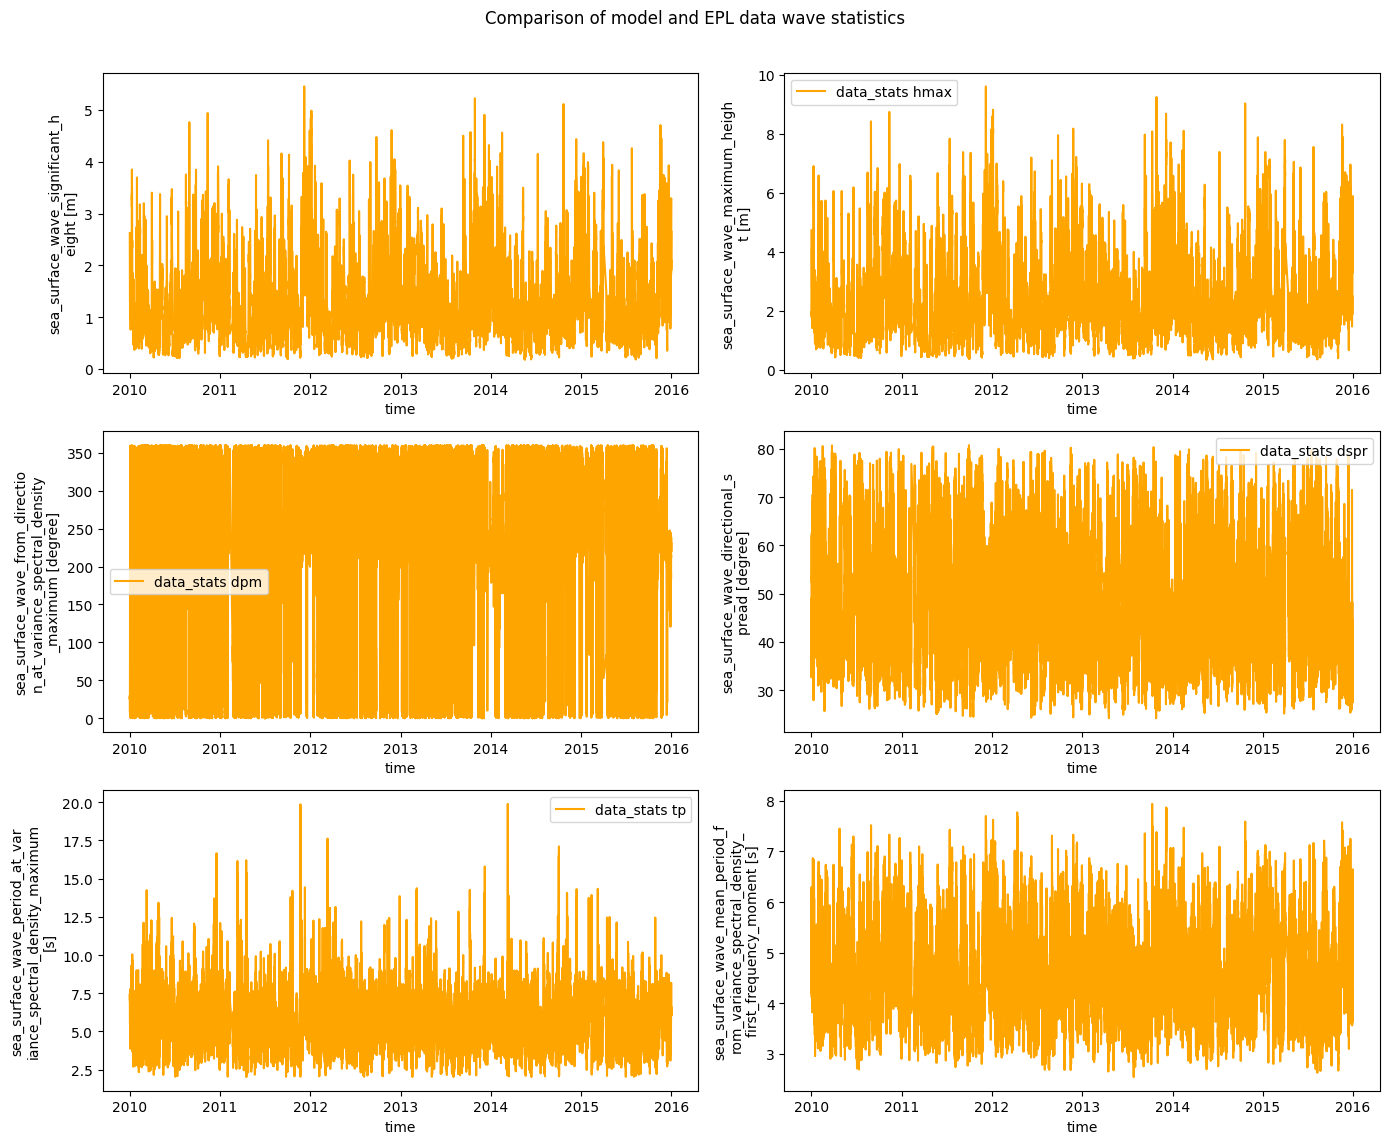

In [20]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 12))
# EPL_common_model_stats.hs.plot(ax=ax1, x="time", label="model_stats hs", color='blue');
EPL_data_stats.hs.plot(ax=ax1, x="time", label="data_stats hs", color='orange');
EPL_data_stats.hmax.plot.line(ax=ax2, x="time", label="data_stats hmax", color='orange');
# EPL_common_model_stats.hmax.plot.line(ax=ax2, x="time", label="model_stats hmax", color='blue');
ax2.legend()

EPL_data_stats.dpm.plot.line(ax=ax3, x="time", label="data_stats dpm", color='orange')
# ax3.set_ylim(-150, 150);
# EPL_common_model_stats.dpm.plot.line(ax=ax3, x="time", label="model_stats dpm", color='blue');
ax3.legend()

EPL_data_stats.dspr.plot.line(ax=ax4, x="time", label="data_stats dspr", color='orange');
# EPL_common_model_stats.dspr.plot.line(ax=ax4, x="time", label="model_stats dspr", color='blue');
ax4.legend()

EPL_data_stats.tp.plot.line(ax=ax5, x="time", label="data_stats tp", color='orange');
# EPL_common_model_stats.tp.plot.line(ax=ax5, x="time", label="model_stats tp", color='blue');
ax5.legend()

EPL_data_stats.tm01.plot.line(ax=ax6, x="time", label="data_stats tm01", color='orange');
# EPL_common_model_stats.tm01.plot.line(ax=ax6, x="time", label="model_stats tm01", color='blue');

fig.suptitle('Comparison of model and EPL data wave statistics')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.draw()

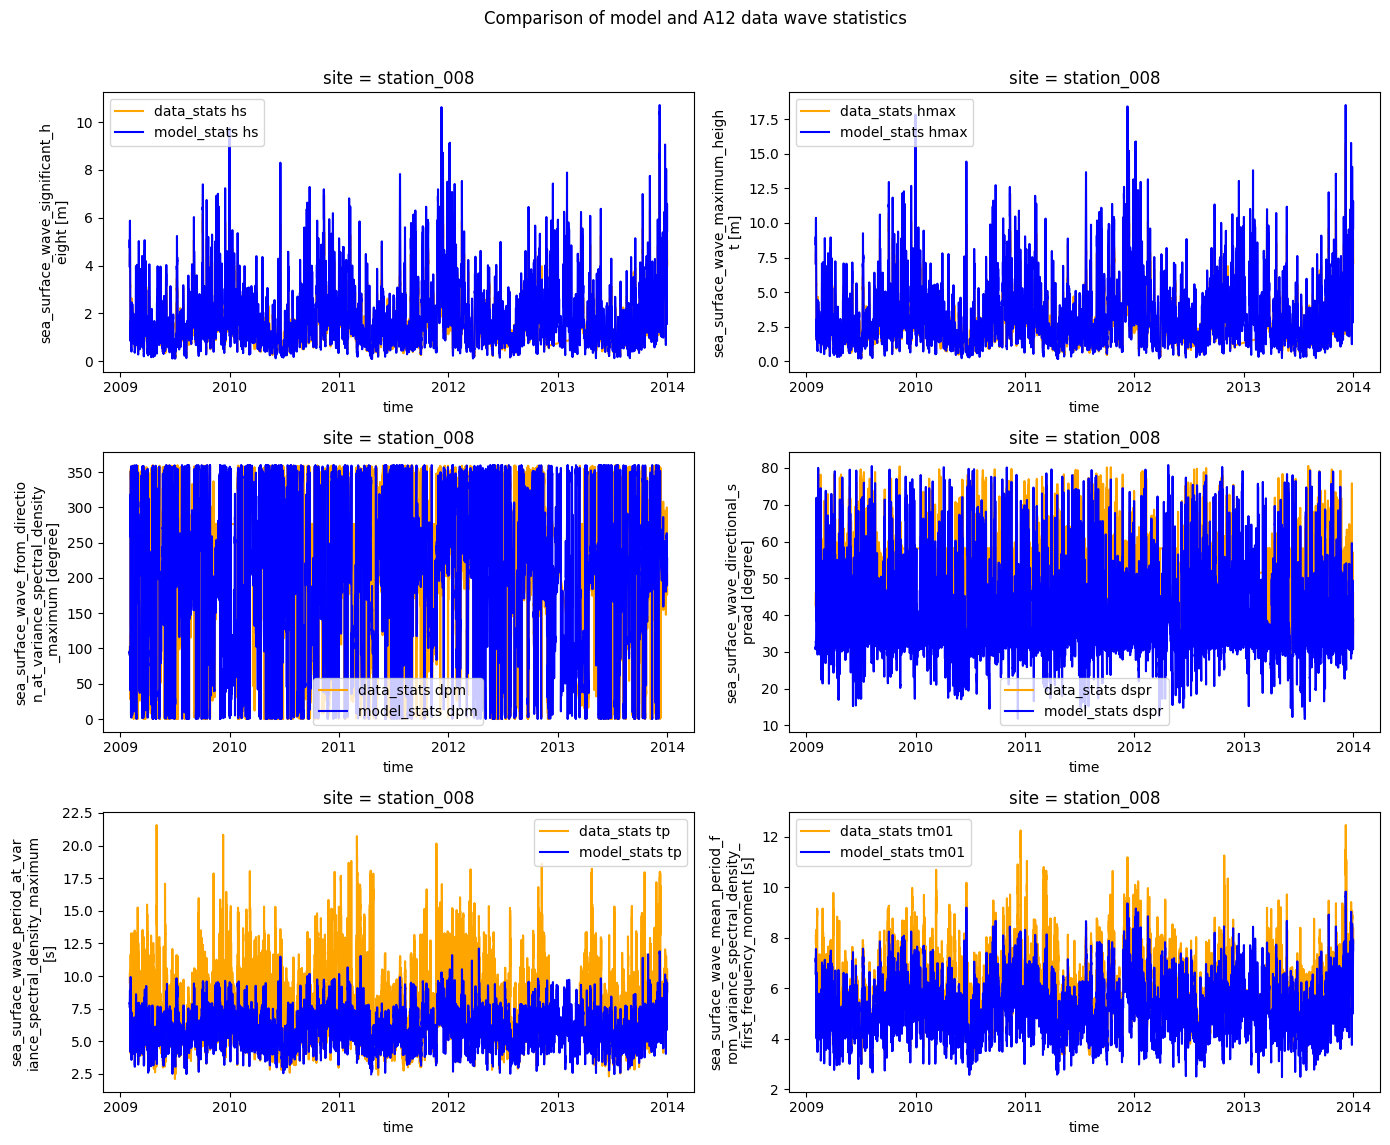

In [21]:
# plt.clf()
# plt.close('all')
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 12))
A12_common_data_stats.hs.plot.line(ax=ax1, x="time", label="data_stats hs", color='orange');
A12_common_model_stats.hs.plot(ax=ax1, x="time", label="model_stats hs", color='blue');
ax1.legend()

A12_common_data_stats.hmax.plot.line(ax=ax2, x="time", label="data_stats hmax", color='orange');
A12_common_model_stats.hmax.plot.line(ax=ax2, x="time", label="model_stats hmax", color='blue');
ax2.legend()

A12_common_data_stats.dpm.plot.line(ax=ax3, x="time", label="data_stats dpm", color='orange');
A12_common_model_stats.dpm.plot.line(ax=ax3, x="time", label="model_stats dpm", color='blue');
ax3.legend()

A12_common_data_stats.dspr.plot.line(ax=ax4, x="time", label="data_stats dspr", color='orange');
A12_common_model_stats.dspr.plot.line(ax=ax4, x="time", label="model_stats dspr", color='blue');
ax4.legend()

A12_common_data_stats.tp.plot.line(ax=ax5, x="time", label="data_stats tp", color='orange');
A12_common_model_stats.tp.plot.line(ax=ax5, x="time", label="model_stats tp", color='blue');
ax5.legend()

A12_common_data_stats.tm01.plot.line(ax=ax6, x="time", label="data_stats tm01", color='orange');
A12_common_model_stats.tm01.plot.line(ax=ax6, x="time", label="model_stats tm01", color='blue');
ax6.legend()

fig.suptitle('Comparison of model and A12 data wave statistics')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.draw()

In [22]:
print(np.max(Hoorn_common_data_stats.hs.values))

15.90970772830224


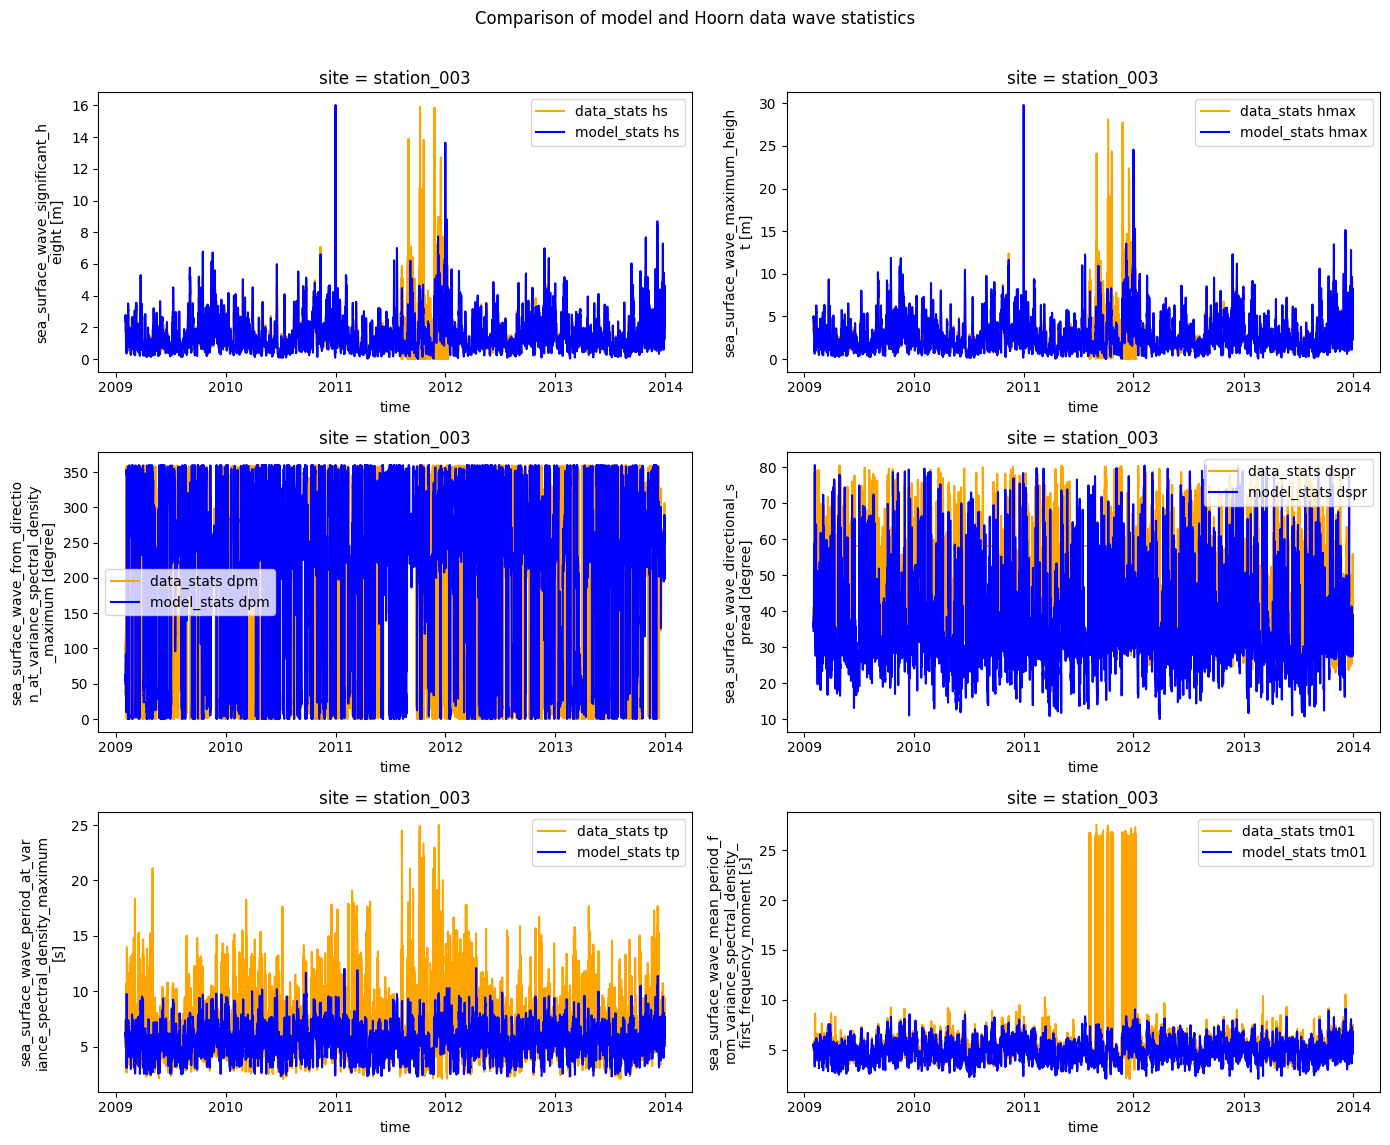

In [23]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14, 12))
Hoorn_common_data_stats.hs.plot.line(ax=ax1, x="time", label="data_stats hs", color='orange');
Hoorn_common_model_stats.hs.plot.line(ax=ax1, x="time", label="model_stats hs", color='blue');
ax1.legend()

Hoorn_common_data_stats.hmax.plot.line(ax=ax2, x="time", label="data_stats hmax", color='orange');
Hoorn_common_model_stats.hmax.plot.line(ax=ax2, x="time", label="model_stats hmax", color='blue');
ax2.legend()

Hoorn_common_data_stats.dpm.plot.line(ax=ax3, x="time", label="data_stats dpm", color='orange');
Hoorn_common_model_stats.dpm.plot.line(ax=ax3, x="time", label="model_stats dpm", color='blue');
ax3.legend()

Hoorn_common_data_stats.dspr.plot.line(ax=ax4, x="time", label="data_stats dspr", color='orange');
Hoorn_common_model_stats.dspr.plot.line(ax=ax4, x="time", label="model_stats dspr", color='blue');
ax4.legend()


Hoorn_common_data_stats.tp.plot.line(ax=ax5, x="time", label="data_stats tp", color='orange');
Hoorn_common_model_stats.tp.plot.line(ax=ax5, x="time", label="model_stats tp", color='blue');
ax5.legend()

Hoorn_common_data_stats.tm01.plot.line(ax=ax6, x="time", label="data_stats tm01", color='orange');
Hoorn_common_model_stats.tm01.plot.line(ax=ax6, x="time", label="model_stats tm01", color='blue');
ax6.legend()

fig.suptitle('Comparison of model and Hoorn data wave statistics')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.draw()

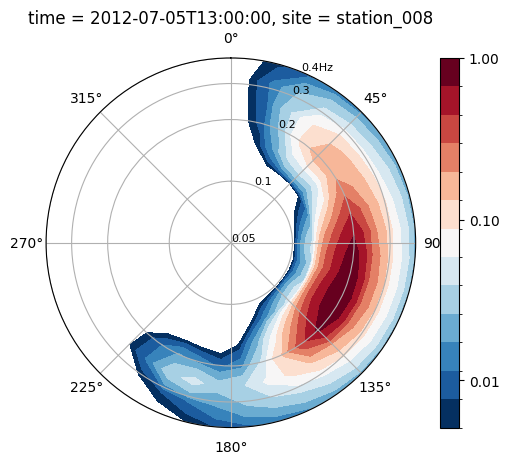

In [24]:
ds_timestep = A12_common_model_dset.isel(time=30000).spec.split(fmin=0.05, fmax=0.4)
ds_timestep.spec.plot()

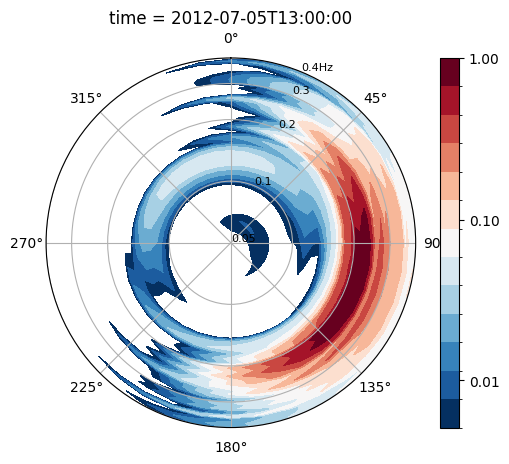

In [25]:
ds_data_timestep = A12_common_data_dset.isel(time=30000).spec.split(fmin=0.05, fmax=0.4)
ds_data_timestep.spec.plot()

[5865, 15571, 24974, 25589, 42448]
[5795, 15452, 24834, 25446, 39781]
[6172, 15564, 23504, 25631, 42441]
[6018, 15283, 22359, 24347, 41154]
A12 timestamps largest hs model: ['2009-10-03T22:00:00.000000000' '2010-11-12T08:00:00.000000000'
 '2011-12-09T04:00:00.000000000' '2012-01-03T20:00:00.000000000'
 '2013-12-06T08:00:00.000000000']
A12 timestamps largest hs data: ['2009-10-03T22:00:00.000000000' '2010-11-12T08:00:00.000000000'
 '2011-12-09T04:00:00.000000000' '2012-01-03T20:00:00.000000000'
 '2013-12-06T08:00:00.000000000']
Hoorn timestamps largest hs model: ['2009-10-16T17:00:00.000000000' '2010-11-12T02:00:00.000000000'
 '2011-10-08T22:00:00.000000000' '2012-01-05T13:00:00.000000000'
 '2013-12-06T00:00:00.000000000']
Hoorn timestamps largest hs data: ['2009-10-16T17:00:00.000000000' '2010-11-12T02:00:00.000000000'
 '2011-10-08T22:00:00.000000000' '2012-01-05T13:00:00.000000000'
 '2013-12-06T00:00:00.000000000']
A12 largest hs model: [7.2619707  6.63551184 9.92015717 9.00028265 9.9

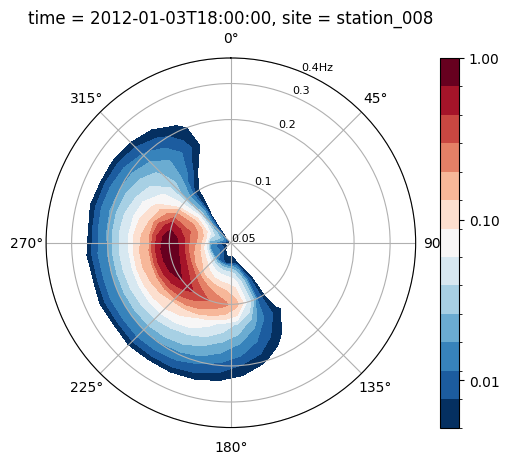

In [26]:
def find_the_index_of_largest_wave_height_of_each_year(df_common_data_stats):
    """
    Find the positional index (0-based) of the largest wave height (hs) for each year.

    Parameters
    ----------
    df_common_data_stats : object
        An object with attribute `hs` as an xarray DataArray with a datetime coordinate named 'time'.

    Returns
    -------
    list of int
        List of positional indices for each year's maximum wave height, in year order.
    """
    hs = df_common_data_stats.hs
    if "time" not in hs.coords:
        raise ValueError("DataArray must have a 'time' coordinate.")

    years = np.unique(hs["time"].dt.year)
    positions = []

    for year in years:
        yearly_mask = hs["time"].dt.year == year
        yearly_data = hs.sel(time=yearly_mask)
        pos_within_year = yearly_data.argmax(dim="time").item()  # index in yearly slice
        absolute_pos = np.flatnonzero(yearly_mask.values)[pos_within_year]  # index in full array
        positions.append(int(absolute_pos))

    return positions

A12_timestamps_data_largest_hs = find_the_index_of_largest_wave_height_of_each_year(A12_common_data_stats)
Hoorn_timestamps_data_largest_hs = find_the_index_of_largest_wave_height_of_each_year(Hoorn_common_data_stats)

def get_position_from_datetime(df_common_data_stats, datetimes):
    """
    Get the positional index/indices for given datetime(s) in the hs time coordinate.

    Parameters
    ----------
    df_common_data_stats : object
        Object with attribute `hs` as an xarray DataArray with a 'time' coordinate.
    datetimes : single datetime-like or list/array of datetime-like
        The datetime(s) to look up.

    Returns
    -------
    int or list of int
        The positional index (0-based) of each datetime in the time coordinate.
    """
    hs = df_common_data_stats.hs
    times = hs.time.values  # numpy datetime64 array

    # Ensure datetimes is iterable
    if not np.iterable(datetimes) or isinstance(datetimes, (np.datetime64, str, pd.Timestamp)):
        datetimes = [datetimes]
        single_input = True
    else:
        single_input = False

    indices = []
    for dt in datetimes:
        idx = np.where(times == np.datetime64(dt))[0]
        if idx.size == 0:
            raise ValueError(f"Datetime {dt} not found in time coordinate.")
        indices.append(int(idx[0]))

    return indices[0] if single_input else indices

A12_timestamps_model_largest_hs = get_position_from_datetime(A12_common_model_stats,A12_common_data_stats['time'][A12_timestamps_data_largest_hs].values)
Hoorn_timestamps_model_largest_hs = get_position_from_datetime(Hoorn_common_model_stats,Hoorn_common_data_stats['time'][Hoorn_timestamps_data_largest_hs].values)

print(A12_timestamps_model_largest_hs)
print(A12_timestamps_data_largest_hs)
print(Hoorn_timestamps_model_largest_hs)
print(Hoorn_timestamps_data_largest_hs)

print("A12 timestamps largest hs model:", A12_common_model_stats['time'][A12_timestamps_model_largest_hs].values)
print("A12 timestamps largest hs data:", A12_common_data_stats['time'][A12_timestamps_data_largest_hs].values)
print("Hoorn timestamps largest hs model:", Hoorn_common_model_stats['time'][Hoorn_timestamps_model_largest_hs].values)
print("Hoorn timestamps largest hs data:", Hoorn_common_data_stats['time'][Hoorn_timestamps_data_largest_hs].values)

print("A12 largest hs model:", A12_common_model_stats.hs[A12_timestamps_model_largest_hs].values)
print("A12 largest hs data:", A12_common_data_stats.hs[A12_timestamps_data_largest_hs].values)
print("Hoorn largest hs model:", Hoorn_common_model_stats.hs[Hoorn_timestamps_model_largest_hs].values)
print("Hoorn largest hs data:", Hoorn_common_data_stats.hs[Hoorn_timestamps_data_largest_hs].values)

ds_model_timestep = A12_common_model_dset.isel(time=A12_timestamps_model_largest_hs[3]).spec.split(fmin=0.05, fmax=0.4)
ds_model_timestep.spec.plot()






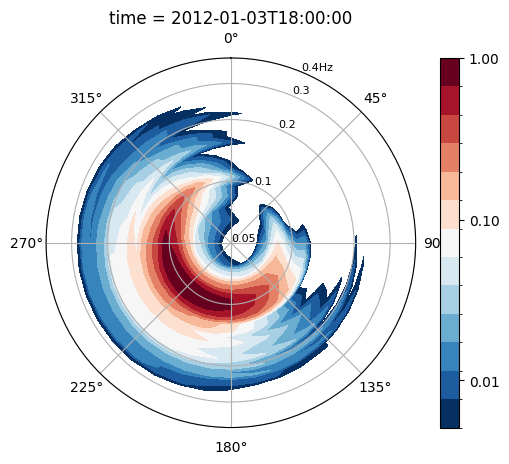

In [27]:
ds_data_timestep = A12_common_data_dset.isel(time=A12_timestamps_model_largest_hs[3]).spec.split(fmin=0.05, fmax=0.4)
ds_data_timestep.spec.plot()

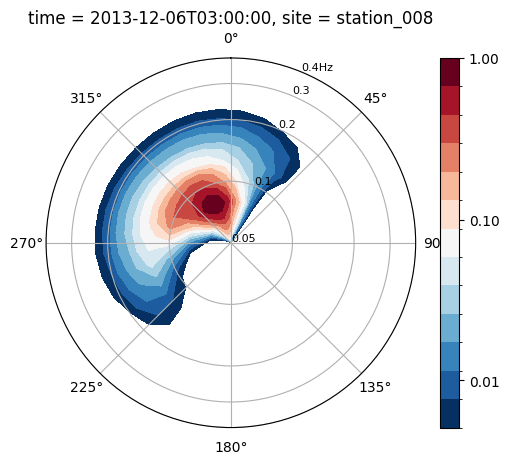

In [28]:
ds_model_timestep = A12_common_model_dset.isel(time=42446).spec.split(fmin=0.05, fmax=0.4)
ds_model_timestep.spec.plot()

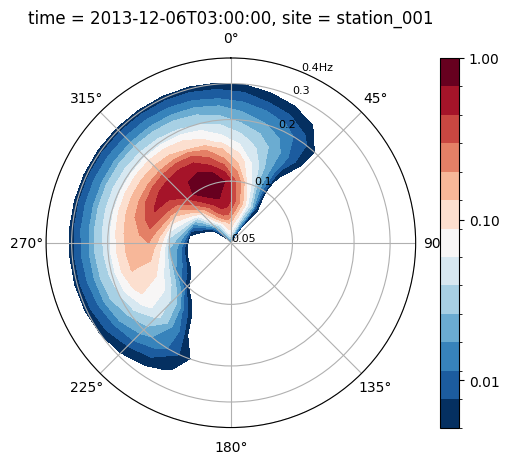

In [44]:
ds_model_timestep = EPL_common_model_dset.isel(time=34443).spec.split(fmin=0.05, fmax=0.4)
ds_model_timestep.spec.plot()

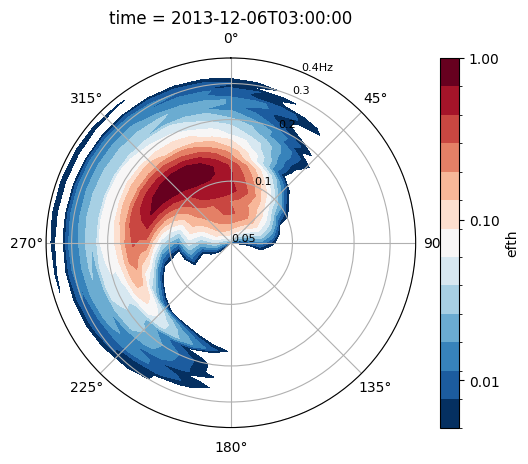

In [45]:
ds_data_timestep = EPL_common_data_dset.isel(time=34443).spec.split(fmin=0.05, fmax=0.4)
ds_data_timestep.spec.plot()

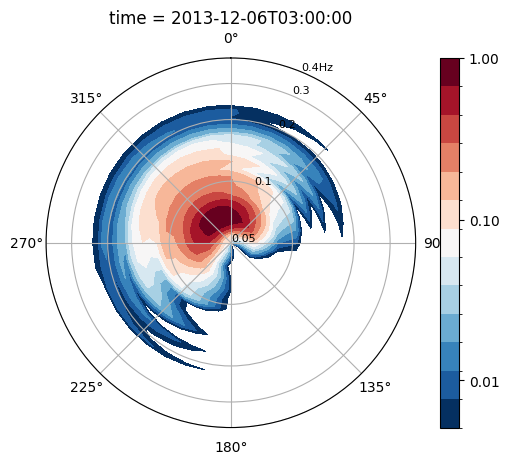

In [29]:
ds_data_timestep = A12_common_data_dset.isel(time=42446).spec.split(fmin=0.05, fmax=0.4)
ds_data_timestep.spec.plot()

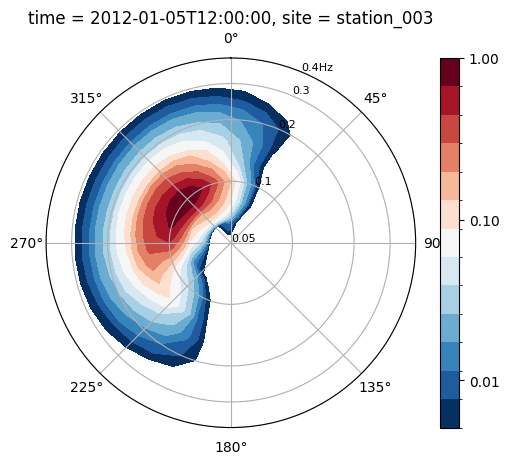

In [30]:
ds_model_timestep = Hoorn_common_model_dset.isel(time=Hoorn_timestamps_model_largest_hs[3]).spec.split(fmin=0.05, fmax=0.4)
ds_model_timestep.spec.plot()

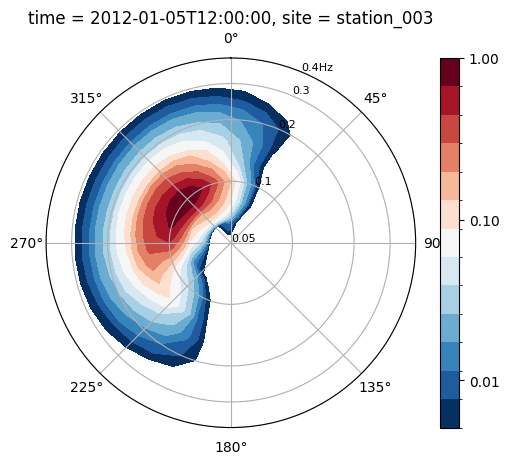

In [31]:
ds_model_timestep = Hoorn_common_model_dset.isel(time=Hoorn_timestamps_model_largest_hs[3]).spec.split(fmin=0.05, fmax=0.4)
ds_model_timestep.spec.plot()

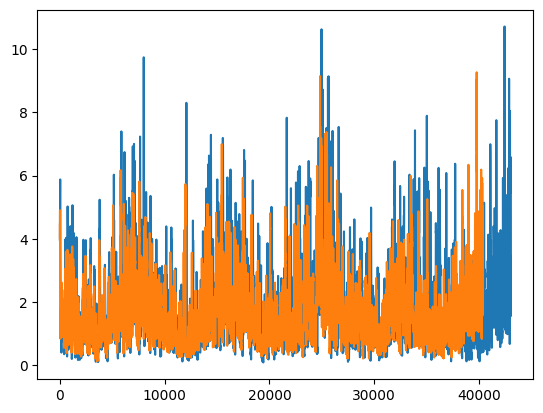

In [32]:
plt.plot(A12_common_model_stats.hs.values)
plt.plot(A12_common_data_stats.hs.values)

In [33]:
# print the total amount of timesteps existing in A12_common_data_dset
print(A12_common_data_dset.dims['time'])
# print the total amount of timesteps existing in A12_common_model_dset
print(A12_common_model_dset.dims['time'])

# print the total amount of timesteps existing in Hoorn_common_data_dset
print(Hoorn_common_data_dset.dims['time'])

# print the total amount of timesteps existing in Hoorn_common_model_dset
print(Hoorn_common_model_dset.dims['time'])

# Extract every thousandth timestep from both call it _timestep_ani
A12_timestep_ani = A12_common_data_dset.isel(time=slice(None, None, 1000))
Hoorn_timestep_ani = Hoorn_common_data_dset.isel(time=slice(None, None, 1000))

43044
43044
43044
43044


/scratch-local/72649/ipykernel_2970878/4030687319.py:2: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(A12_common_data_dset.dims['time'])
/scratch-local/72649/ipykernel_2970878/4030687319.py:4: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(A12_common_model_dset.dims['time'])
/scratch-local/72649/ipykernel_2970878/4030687319.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print

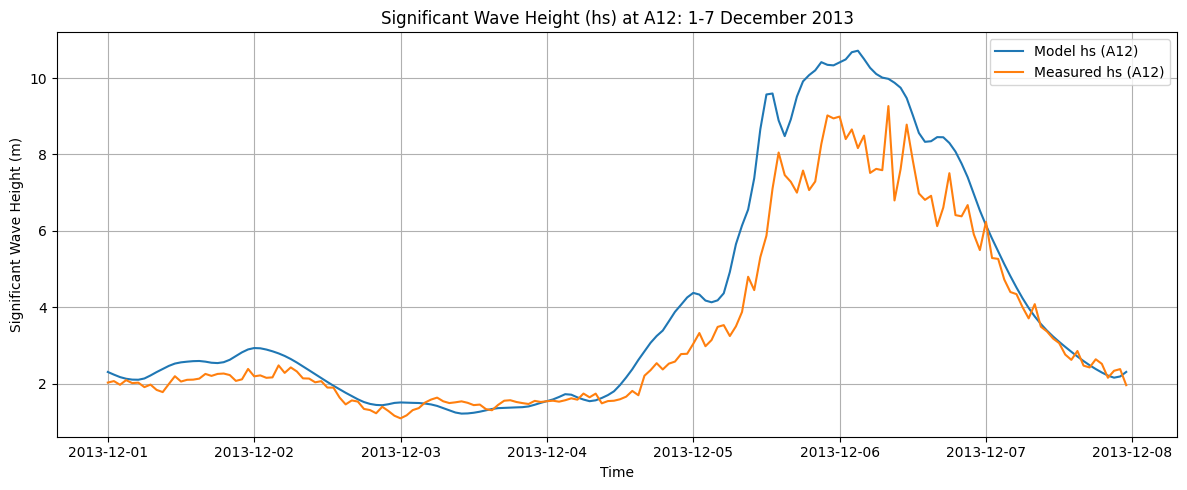

In [34]:
# Select the time range
start_time = np.datetime64('2013-12-01')
end_time = np.datetime64('2013-12-07T23:59:59')

# For model: use A12_common_model_stats.hs (site index 7 is A12)
model_hs_dec = A12_common_model_stats.hs.sel(time=slice(start_time, end_time))

# For measurements: use A12_common_data_stats.hs
data_hs_dec = A12_common_data_stats.hs.sel(time=slice(start_time, end_time))

plt.figure(figsize=(12, 5))
plt.plot(model_hs_dec['time'], model_hs_dec, label='Model hs (A12)')
plt.plot(data_hs_dec['time'], data_hs_dec, label='Measured hs (A12)')
plt.ylabel('Significant Wave Height (m)')
plt.xlabel('Time')
plt.title('Significant Wave Height (hs) at A12: 1-7 December 2013')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

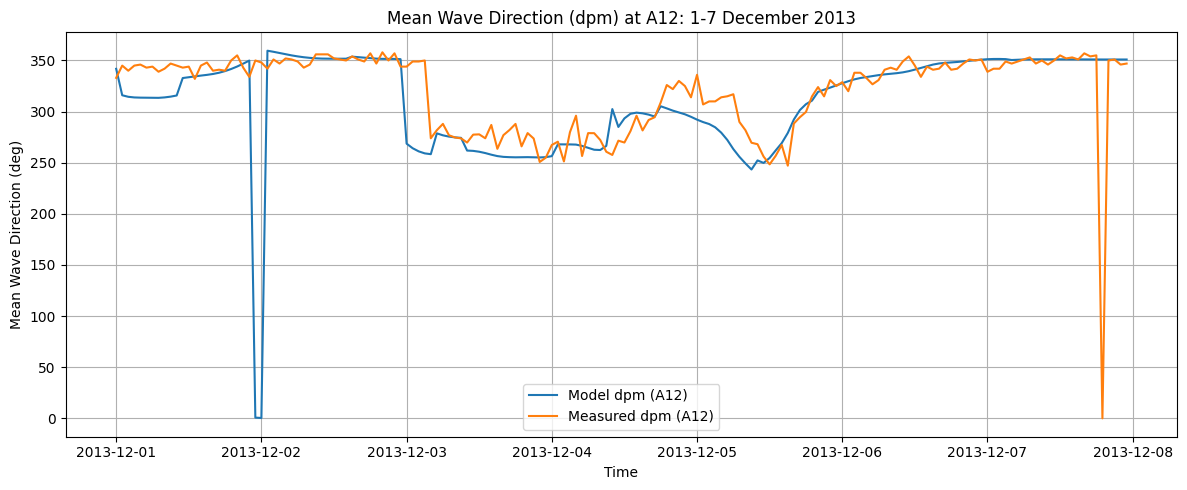

In [35]:
# Plot mean wave direction (dpm) for the same time range

# For model: use A12_common_model_stats.dpm (site index 7 is A12)
model_dir_dec = A12_common_model_stats.dpm.sel(time=slice(start_time, end_time))

# For measurements: use A12_common_data_stats.dpm
data_dir_dec = A12_common_data_stats.dpm.sel(time=slice(start_time, end_time))

plt.figure(figsize=(12, 5))
plt.plot(model_dir_dec['time'], model_dir_dec, label='Model dpm (A12)')
plt.plot(data_dir_dec['time'], data_dir_dec, label='Measured dpm (A12)')
plt.ylabel('Mean Wave Direction (deg)')
plt.xlabel('Time')
plt.title('Mean Wave Direction (dpm) at A12: 1-7 December 2013')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

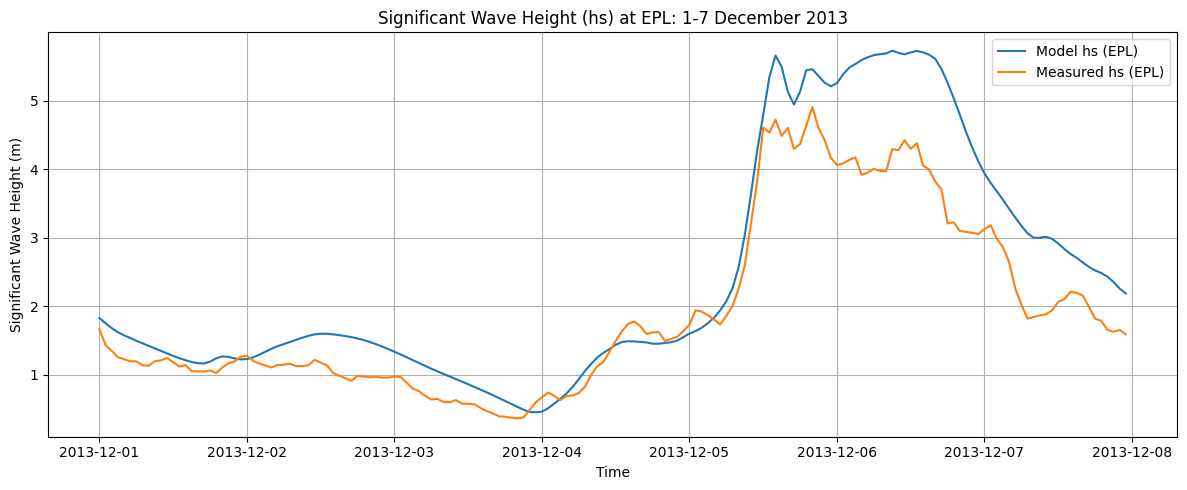

In [46]:
# Select the time range
start_time = np.datetime64('2013-12-01')
end_time = np.datetime64('2013-12-07T23:59:59')

# For model: use EPL_common_model_stats.hs (site index 0 is EPL)
model_hs_dec = EPL_common_model_stats.hs.sel(time=slice(start_time, end_time))

# For measurements: use EPL_common_data_stats.hs
data_hs_dec = EPL_common_data_stats.hs.sel(time=slice(start_time, end_time))

plt.figure(figsize=(12, 5))
plt.plot(model_hs_dec['time'], model_hs_dec, label='Model hs (EPL)')
plt.plot(data_hs_dec['time'], data_hs_dec, label='Measured hs (EPL)')
plt.ylabel('Significant Wave Height (m)')
plt.xlabel('Time')
plt.title('Significant Wave Height (hs) at EPL: 1-7 December 2013')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

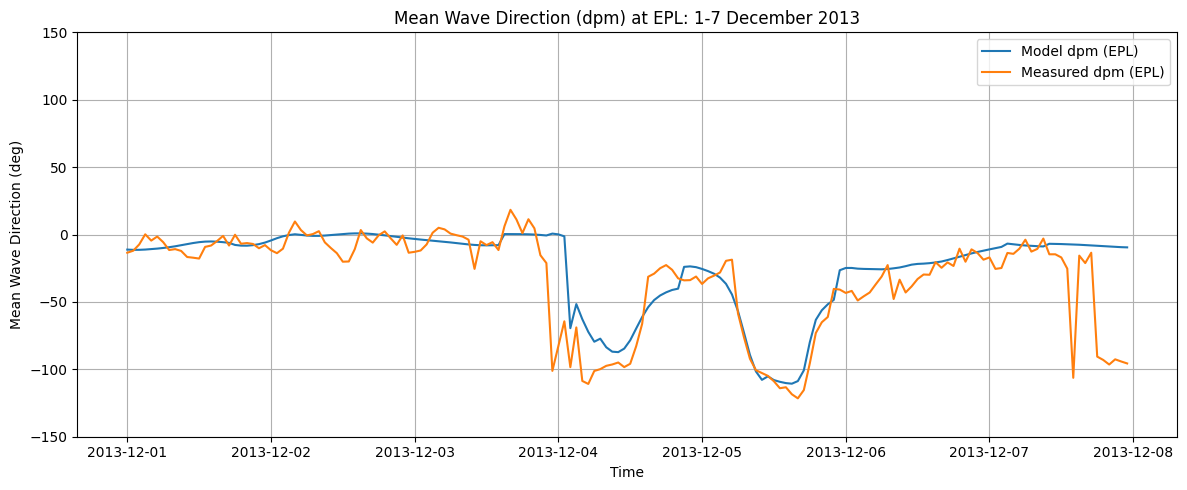

: 

In [ ]:
# Plot mean wave direction (dpm) for the same time range at EPL

# For model: use EPL_common_model_stats.dpm (site index 0 is EPL)
model_dir_dec = EPL_common_model_stats.dpm.sel(time=slice(start_time, end_time))
# For measurements: use EPL_common_data_stats.dpm
data_dir_dec = EPL_common_data_stats.dpm.sel(time=slice(start_time, end_time))

# Convert directions from 0-360 to -180 to 180
model_dir_dec = ((model_dir_dec + 180) % 360) - 180
data_dir_dec = ((data_dir_dec + 180) % 360) - 180

plt.figure(figsize=(12, 5))
plt.plot(model_dir_dec['time'], model_dir_dec, label='Model dpm (EPL)')
plt.plot(data_dir_dec['time'], data_dir_dec, label='Measured dpm (EPL)')
plt.ylabel('Mean Wave Direction (deg)')
plt.xlabel('Time')
plt.ylim(-150,150)
plt.title('Mean Wave Direction (dpm) at EPL: 1-7 December 2013')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()